# **Detecting Deepfake Images through Neural Network-based Analysis**

**Deepfake technology has advanced rapidly, enabling the creation of highly realistic forged images that can be used for deceptive purposes. The potential misuse of deepfake images poses a significant threat to the integrity of digital media. Therefore, there is a critical need for effective and reliable methods to detect deepfake images.**

**The primary objective of this research is to develop and implement a robust deepfake image detection system using neural network-based analysis. The system aims to accurately distinguish between authentic and manipulated images, contributing to the enhancement of media forensics and trustworthiness in digital content.**

# Significance

**The successful development of an accurate and efficient deepfake image detection system will have broad applications in preserving the authenticity of digital media, combating misinformation, and safeguarding the integrity of visual content on the internet.**


# Importing Libraries 

**This part of the code imports necessary libraries, especially TensorFlow, and prints the TensorFlow version.**

In [2]:
# Checking TensorFlow Version
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [1]:
import os
import joblib
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.xception import preprocess_input
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#  Loading and Preprocessing Data

**This section loads and preprocesses the dataset, ensuring a balanced distribution of real and fake images. It also splits the data into training, validation, and test sets.**

**Dataset used for training our model is 'deepfake-face dataset'**

**The link for dataset is : https://www.kaggle.com/datasets/dagnelies/deepfake-faces/**

In [2]:
# Load and preprocess the data
def get_data():
    return pd.read_csv('../input/deepfake-faces/metadata.csv')

In [3]:
meta = get_data()
sample_size = 16000

# Select a sample of real and fake images
real_df = meta[meta["label"] == "REAL"]
fake_df = meta[meta["label"] == "FAKE"]
real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)
sample_meta = pd.concat([real_df, fake_df])

# Split the data into training, validation, and test sets
Train_set, Test_set = train_test_split(sample_meta, test_size=0.2, random_state=42, stratify=sample_meta['label'])
Train_set, Val_set = train_test_split(Train_set, test_size=0.25, random_state=42, stratify=Train_set['label'])

# Retrieving Dataset

**This part defines a function to retrieve images and labels from the dataset. It then applies this function to the training, validation, and test sets.**

In [4]:
def retrieve_dataset(set_name):
    images, labels = [], []
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        images.append(cv2.imread('../input/deepfake-faces/faces_224/' + img[:-4] + '.jpg'))
        if(imclass == 'FAKE'):
            labels.append(1)
        else:
            labels.append(0)
    return np.array(images), np.array(labels)

In [5]:
X_train, y_train = retrieve_dataset(Train_set)
X_val, y_val = retrieve_dataset(Val_set)
X_test, y_test = retrieve_dataset(Test_set)

tf.random.set_seed(42)

# Building the Model

**This section defines a Convolutional Neural Network (CNN) using TensorFlow's Keras API. The model is compiled with binary crossentropy loss and Nadam optimizer.**

In [6]:
from functools import partial

tf.random.set_seed(42) 
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

In [8]:
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 401408)            0

# Training the Model

**The model is trained on the training set for 5 epochs, and the training history is stored in the history variable.**

In [9]:
history = model.fit(X_train, y_train, epochs=5,batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/5
300/300 [==============================] - 60s 156ms/step - loss: 31.2464 - accuracy: 0.5010 - val_loss: 0.6938 - val_accuracy: 0.4997
Epoch 2/5
300/300 [==============================] - 44s 148ms/step - loss: 0.6940 - accuracy: 0.4904 - val_loss: 0.6942 - val_accuracy: 0.5020
Epoch 3/5
300/300 [==============================] - 44s 148ms/step - loss: 0.7528 - accuracy: 0.4996 - val_loss: 0.6945 - val_accuracy: 0.4995
Epoch 4/5
300/300 [==============================] - 44s 148ms/step - loss: 0.7059 - accuracy: 0.5076 - val_loss: 0.6937 - val_accuracy: 0.5031
Epoch 5/5
300/300 [==============================] - 44s 148ms/step - loss: 0.6934 - accuracy: 0.5008 - val_loss: 0.6928 - val_accuracy: 0.5027


# Evaluating Model Performance

**This section evaluates the model's performance on the test set and prints the evaluation scores.**

In [10]:
score = model.evaluate(X_test, y_test)

200/200 [==============================] - 6s 24ms/step - loss: 290769.9062 - accuracy: 0.5000


# Plotting Model Performance

**This part plots the model's accuracy and loss on both the training and validation sets across epochs.**

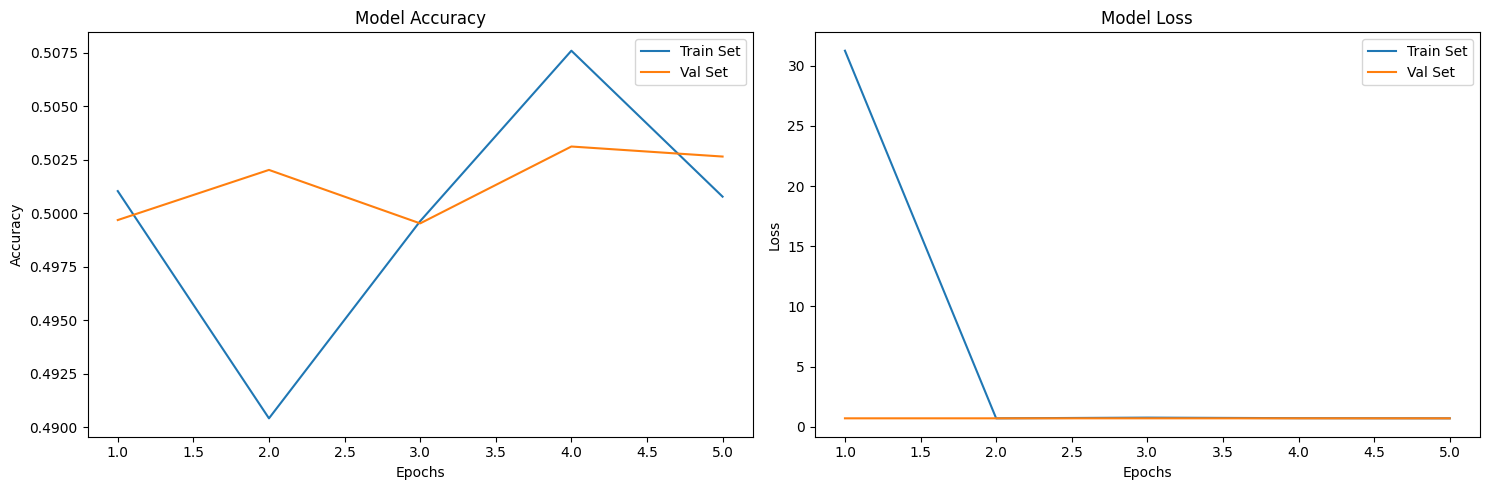

In [11]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

# Preprocessing Data for TensorFlow Dataset

**It creates TensorFlow datasets from the numpy arrays of the training, validation, and test sets.**

In [7]:
train_set_raw=tf.data.Dataset.from_tensor_slices((X_train,y_train))
valid_set_raw=tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_set_raw=tf.data.Dataset.from_tensor_slices((X_test,y_test))

# Clearing Keras Session and Preprocessing Data for Training

**Preprocess the keras data for training**

In [8]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32
preprocess = tf.keras.applications.xception.preprocess_input
train_set = train_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)

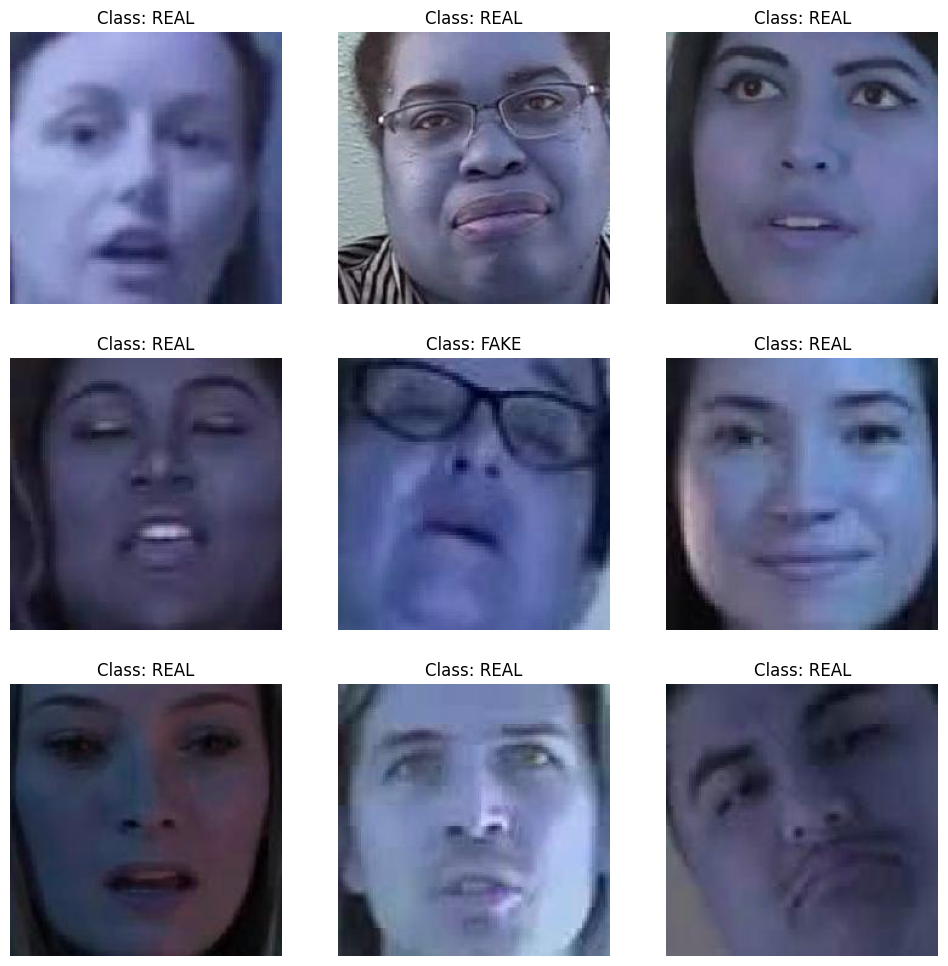

In [9]:
# displays the first 9 images in the first batch of valid_set

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [10]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.2, seed=42)
])

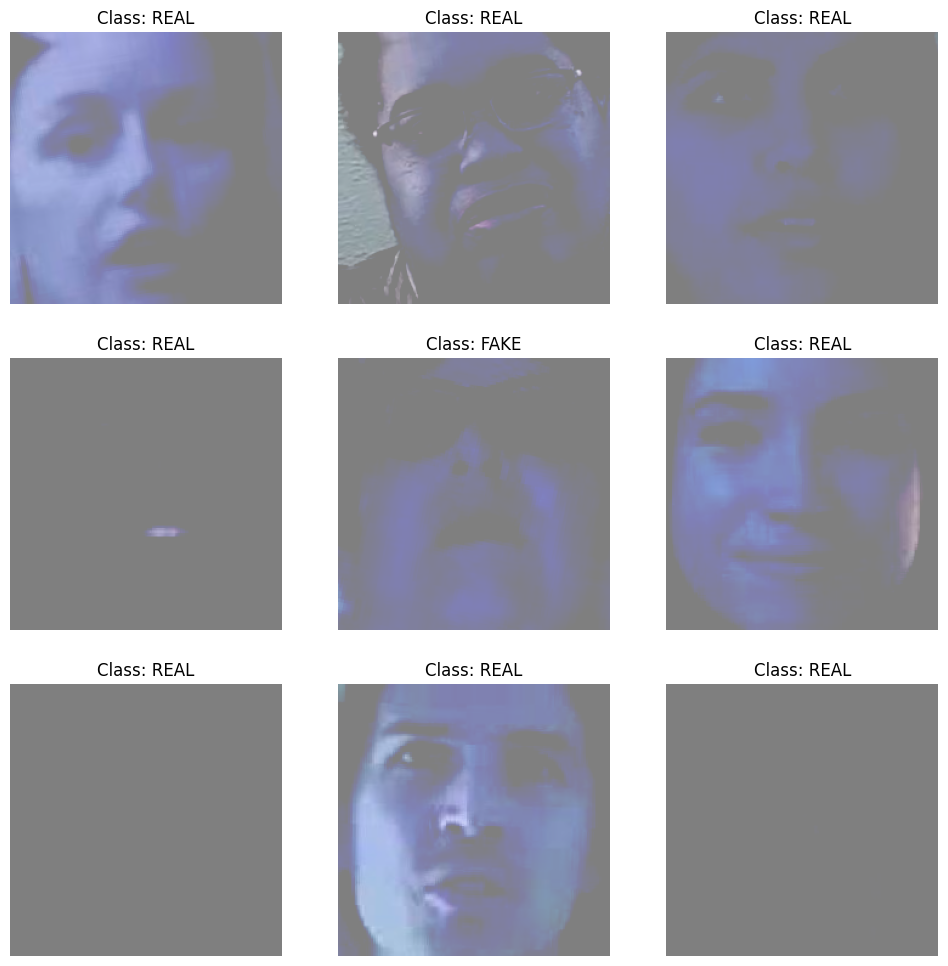

In [11]:
#  displays the same first 9 images, after augmentation

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

# Applying Xception learning for training

In [33]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [34]:
for layer in base_model.layers:
    layer.trainable = False

In [35]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
600/600 [==============================] - 71s 104ms/step - loss: 0.9884 - accuracy: 0.5892 - val_loss: 0.7168 - val_accuracy: 0.6534
Epoch 2/3
600/600 [==============================] - 61s 102ms/step - loss: 0.9069 - accuracy: 0.6258 - val_loss: 0.6987 - val_accuracy: 0.6683
Epoch 3/3
600/600 [==============================] - 61s 102ms/step - loss: 0.9284 - accuracy: 0.6265 - val_loss: 1.4831 - val_accuracy: 0.5556


In [37]:
model.evaluate(test_set)

200/200 [==============================] - 15s 73ms/step - loss: 1.4755 - accuracy: 0.5577


[1.475511908531189, 0.5576562285423279]

In [36]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_1                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [39]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
600/600 [==============================] - 114s 176ms/step - loss: 0.0815 - accuracy: 0.9698 - val_loss: 0.5556 - val_accuracy: 0.8316
Epoch 2/10
600/600 [==============================] - 105s 174ms/step - loss: 0.0574 - accuracy: 0.9805 - val_loss: 0.5978 - val_accuracy: 0.8380
Epoch 3/10
600/600 [==============================] - 105s 174ms/step - loss: 0.0484 - accuracy: 0.9832 - val_loss: 0.4966 - val_accuracy: 0.8616
Epoch 4/10
600/600 [==============================] - 105s 175ms/step - loss: 0.0400 - accuracy: 0.9864 - val_loss: 0.6199 - val_accuracy: 0.8445
Epoch 5/10
600/600 [==============================] - 105s 174ms/step - loss: 0.0377 - accuracy: 0.9871 - val_loss: 0.6057 - val_accuracy: 0.8481
Epoch 6/10
600/600 [==============================] - 105s 175ms/step - loss: 0.0279 - accuracy: 0.9902 - val_loss: 0.6269 - val_accuracy: 0.8555
Epoch 7/10
600/600 [==============================] - 105s 174ms/step - loss: 0.0265 - accuracy: 0.9908 - val_loss: 0.5222 -

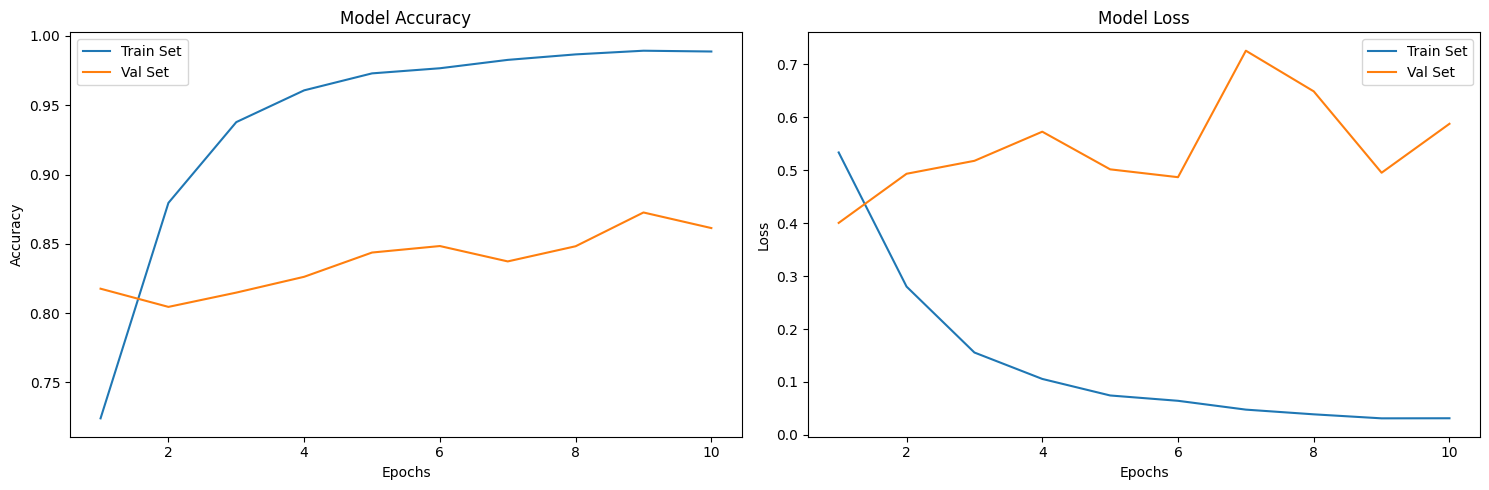

In [24]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [40]:
model.evaluate(test_set)
# The model accuracy finally reaches to 81.9%

200/200 [==============================] - 15s 73ms/step - loss: 0.6406 - accuracy: 0.8602


[0.6406444311141968, 0.860156238079071]

# Save the model for future testing purpose

In [41]:
model.save('xception_deepfake_image.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
import os
print(os.getcwd())


/kaggle/working


In [42]:
import joblib
# Save the trained model using joblib
joblib.dump(model, 'model.joblib')

['model.joblib']

In [8]:
model_path = '/kaggle/working/model.pkl'


# Knowing the directory where the model is saved

In [9]:
import os
cwd = os.getcwd()
print(cwd)


/kaggle/working


# Creating a GUI for user freindly intraction

**A simple Graphical User Interface is developed using ipwidgets framework that comes inbuilt with python for the prection purpose**

**The Steps involve**

**1.running the below piece of code**

**2.Uploading the image**

**3.Clicking Detect Deepfake button**

**4.Knowing weather the image is real or fake**

In [12]:
import os
import tensorflow as tf
import ipywidgets as widgets
from IPython.display import display, clear_output
import cv2
import numpy as np
from tensorflow.keras.applications.xception import preprocess_input

# Load the trained model
model = tf.keras.models.load_model('/kaggle/input/xception-deefake-image-h5/xception_deepfake_image.h5')

# Create widgets
image_widget = widgets.Image(format='png', width=300, height=300)
upload_button = widgets.FileUpload(description="Upload Image")
detect_button = widgets.Button(description="Detect Deepfake")
output_label = widgets.Label()

# Define the detection function
def detect_deepfake(image_path):
    try:
        print(f"Image path: {image_path}")

        # Check if the file exists
        if not os.path.exists(image_path):
            raise ValueError(f"File not found: {image_path}")

        img = cv2.imread(image_path)

        if img is None:
            raise ValueError(f"Failed to load image from {image_path}")

        print(f"Original Image shape: {img.shape}")

        # Resize to match model input shape
        img = cv2.resize(img, (224, 224))
        print(f"Resized Image shape: {img.shape}")

        img = preprocess_input(img)
        img = np.expand_dims(img, axis=0)
        print(f"Processed Image shape: {img.shape}")

        prediction = model.predict(img)
        print(f"Model Prediction: {prediction}")

        # Interpret prediction with adjusted threshold
        threshold = 0.5
        if prediction[0][0] > threshold:
            result = "Fake"
        else:
            result = "Real"


        return result
    except Exception as e:
        # Print the complete error message
        import traceback
        traceback.print_exc()
        return f"Error: {str(e)}"

# Define event handlers
def on_upload_button_click(change):
    if upload_button.value:
        # Get the uploaded file
        image_path = list(upload_button.value.keys())[0]
        image_data = upload_button.value[image_path]["content"]

        # Save the uploaded image with a modified file name without spaces
        modified_image_path = '/kaggle/working/' + image_path.replace(" ", "_")
        with open(modified_image_path, "wb") as f:
            f.write(image_data)

        # Display the uploaded image
        image_widget.value = image_data

        # Detect deepfake
        result = detect_deepfake(modified_image_path)
        output_label.value = f"Prediction: {result}"

def on_detect_button_click(b):
    if upload_button.value:
        image_path = list(upload_button.value.keys())[0]
        image_data = upload_button.value[image_path]["content"]

        # Save the uploaded image with a modified file name without spaces
        modified_image_path = '/kaggle/working/' + image_path.replace(" ", "_")
        with open(modified_image_path, "wb") as f:
            f.write(image_data)

        # Display the uploaded image
        image_widget.value = image_data

        # Detect deepfake
        result = detect_deepfake(modified_image_path)
        output_label.value = f"Prediction: {result}"

# Attach event handlers
upload_button.observe(on_upload_button_click, names='_counter')
detect_button.on_click(on_detect_button_click)

# Display widgets
display(upload_button, image_widget, detect_button, output_label)


FileUpload(value={}, description='Upload Image')

Image(value=b'', height='300', width='300')

Button(description='Detect Deepfake', style=ButtonStyle())

Label(value='')